In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
!pip install sqlalchemy==1.4
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

from sqlalchemy import create_engine, MetaData

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
engine

Engine(sqlite:///Resources/hawaii.sqlite)

In [5]:
# reflect an existing database into a new model
with engine.connect() as conn:
    result1 = conn.execute(text("SELECT * FROM measurement LIMIT 5;")).fetchall()
    result2 = conn.execute(text("SELECT * FROM station LIMIT 5;")).fetchall()

# reflect the tables
print(result1)
print(result2)

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0), (2, 'USC00519397', '2010-01-02', 0.0, 63.0), (3, 'USC00519397', '2010-01-03', 0.0, 74.0), (4, 'USC00519397', '2010-01-04', 0.0, 76.0), (5, 'USC00519397', '2010-01-06', None, 73.0)]
[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9), (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]


In [6]:
# View all of the classes that automap found
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

# View all of the classes
all_classes = Base.classes.keys()
print("All Classes:", all_classes)

All Classes: ['measurement', 'station']


In [7]:
# Save references to each table
Base.prepare(engine, reflect=True)

measurement = Base.classes.measurement
station = Base.classes.station


C:\Users\arpitas\AppData\Local\anaconda3\Lib\site-packages\sqlalchemy\orm\clsregistry.py:176: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.measurement, and will be replaced in the string-lookup table.
  util.warn(
C:\Users\arpitas\AppData\Local\anaconda3\Lib\site-packages\sqlalchemy\orm\clsregistry.py:176: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.station, and will be replaced in the string-lookup table.
  util.warn(


In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)
session

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

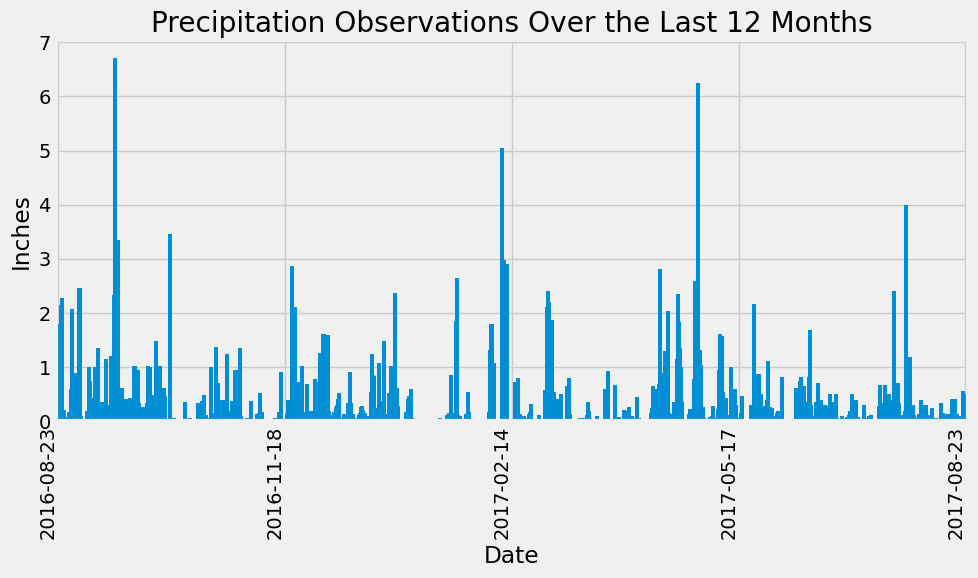

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
session.query(measurement.date).order_by(measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
precipitation_year_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= year_ago).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_year_data, columns=['date', 'prcp'])
precipitation_df 

# Sort the dataframe by date
precipitation_df.sort_values(by='date', inplace= True)

#creating the bar chart
precipitation_df.plot.bar(x='date', y='prcp', figsize=(10, 6), legend=False, width=10)
plt.title('Precipitation Observations Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Inches')

# Limit the number of x-axis tick marks to show only 5 dates
n = 5
step = len(precipitation_df) // (n - 1)
plt.xticks(range(0, len(precipitation_df), step), precipitation_df['date'][::step], rotation=90, ha='right')

plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(func.distinct(measurement.station))).scalar()

9

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station).label('station_count')).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
most_active_stations



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281')
most_active_station

temperatures_df= pd.DataFrame(most_active_station)
temperatures_df

min = temperatures_df['tobs'].min()
max = temperatures_df['tobs'].max()
average = temperatures_df['tobs'].mean()

temp_df = pd.DataFrame({
    'minimum': [min],
    'maximum': [max],
    'average': [average]
})

# Display the DataFrame
print(temp_df)

   minimum  maximum    average
0     54.0     85.0  71.663781


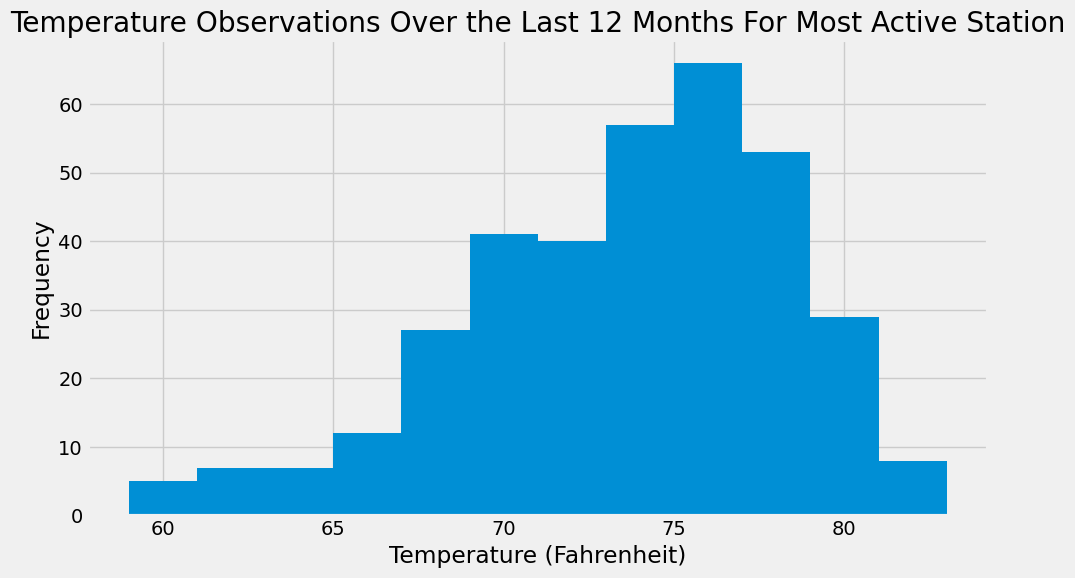

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_most_active_station_year_df = session.query(measurement.date, measurement.tobs).\
    filter((measurement.date >= year_ago) & (measurement.station =='USC00519281')).\
    order_by(measurement.date).all()

# Convert to a DataFrame
temp_most_active_station_df = pd.DataFrame(temp_most_active_station_year_df, columns=['date', 'tobs'])

# Plot the histogram using matplotlib
temp_most_active_station_df['tobs'].plot.hist(bins=12, figsize=(10, 6))
plt.title('Temperature Observations Over the Last 12 Months For Most Active Station')
plt.xlabel('Temperature (Fahrenheit)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [20]:
# Close Session
session.close()